In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')

In [4]:
 df = pd.read_csv('C:/lineal/CAR DETAILS FROM CAR DEKHO.csv')

In [8]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [10]:
df.describe()

,year,selling_price,km_driven
count,4340.000000,4.340000e+03,4340.000000
mean,2013.090783,5.041273e+05,66215.777419
std,4.215344,5.785487e+05,46644.102194
min,1992.000000,2.000000e+04,1.000000
25%,2011.000000,2.087498e+05,35000.000000
50%,2014.000000,3.500000e+05,60000.000000
75%,2016.000000,6.000000e+05,90000.000000
max,2020.000000,8.900000e+06,806599.000000


In [12]:
df.isnull().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64

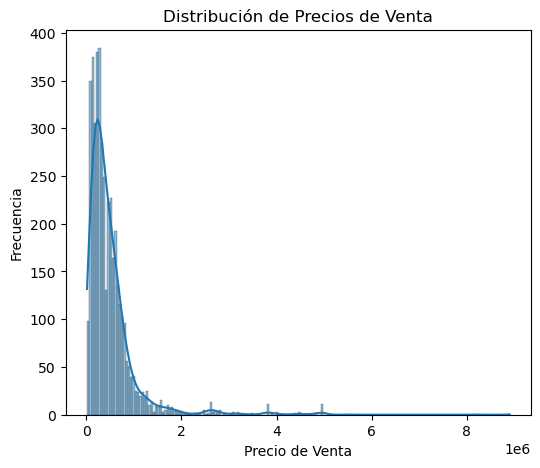

In [20]:
plt.figure(figsize=(6, 5))
sns.histplot(df['selling_price'], kde=True)
plt.title('Distribución de Precios de Venta')
plt.xlabel('Precio de Venta')
plt.ylabel('Frecuencia')
plt.show()

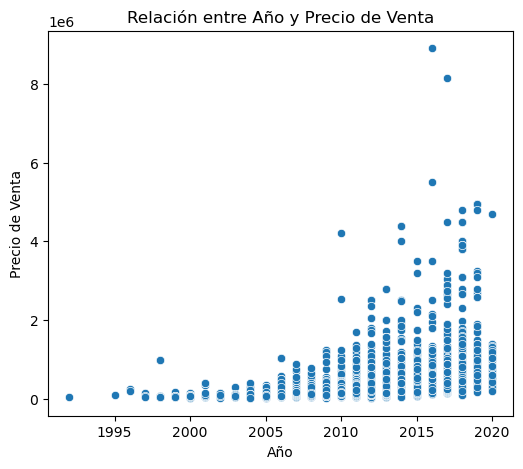

In [24]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x='year', y='selling_price', data=df)
plt.title('Relación entre Año y Precio de Venta')
plt.xlabel('Año')
plt.ylabel('Precio de Venta')
plt.show()

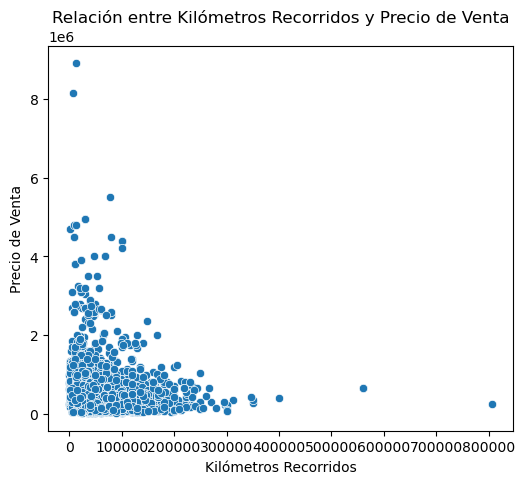

In [28]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x='km_driven', y='selling_price', data=df)
plt.title('Relación entre Kilómetros Recorridos y Precio de Venta')
plt.xlabel('Kilómetros Recorridos')
plt.ylabel('Precio de Venta')
plt.show()

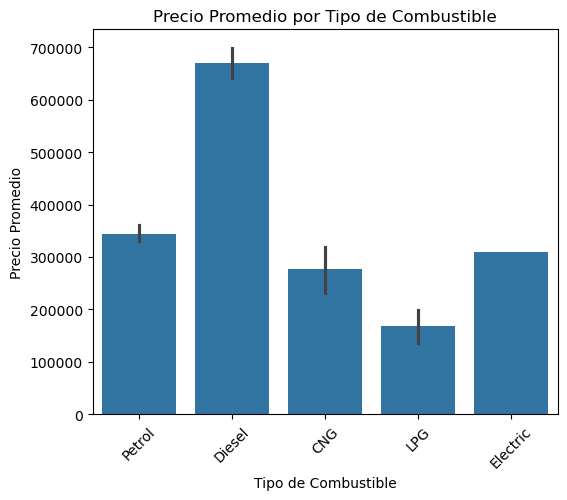

In [30]:
plt.figure(figsize=(6, 5))
sns.barplot(x='fuel', y='selling_price', data=df)
plt.title('Precio Promedio por Tipo de Combustible')
plt.xlabel('Tipo de Combustible')
plt.ylabel('Precio Promedio')
plt.xticks(rotation=45)
plt.show()

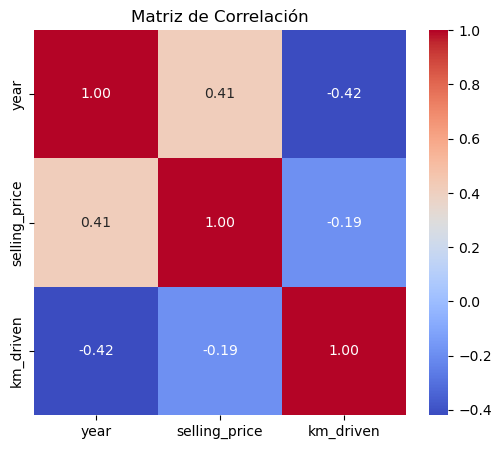

In [34]:
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(6, 5))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

In [36]:
df_processed = df.copy()

In [38]:
Q1 = df_processed['selling_price'].quantile(0.25)
Q3 = df_processed['selling_price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((df_processed['selling_price'] < lower_bound) | 
            (df_processed['selling_price'] > upper_bound))
print(f"Número de valores atípicos en precio: {outliers.sum()}")


Número de valores atípicos en precio: 271


In [44]:
df_processed.loc[df_processed['selling_price'] > upper_bound, 'selling_price'] = upper_bound
df_processed.loc[df_processed['selling_price'] < lower_bound, 'selling_price'] = lower_bound

In [42]:
df_processed['car_age'] = 2024 - df_processed['year']

Característica 'car_age' creada


In [46]:
df_processed['log_selling_price'] = np.log1p(df_processed['selling_price'])

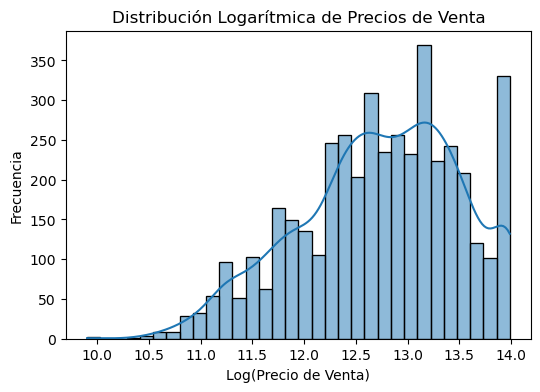

In [100]:
plt.figure(figsize=(6, 4))
sns.histplot(df_processed['log_selling_price'], kde=True)
plt.title('Distribución Logarítmica de Precios de Venta')
plt.xlabel('Log(Precio de Venta)')
plt.ylabel('Frecuencia')
plt.show()

In [50]:
X = df_processed.drop(['selling_price', 'log_selling_price'], axis=1)
y = df_processed['log_selling_price'] 

In [52]:
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

In [54]:
print(f"Variables numéricas: {numerical_cols}")
print(f"Variables categóricas: {categorical_cols}")

Variables numéricas: ['year', 'km_driven', 'car_age']
Variables categóricas: ['name', 'fuel', 'seller_type', 'transmission', 'owner']


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (3472, 8)
Tamaño del conjunto de prueba: (868, 8)


In [66]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler()),('selector', SelectKBest(f_regression, k='all'))])

In [64]:
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [68]:
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_cols),('cat', categorical_transformer, categorical_cols)])

In [70]:
model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', LinearRegression())])

In [72]:
model.fit(X_train, y_train)
print("Modelo entrenado correctamente")

Modelo entrenado correctamente


In [74]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [76]:
y_train_pred_original = np.expm1(y_train_pred)
y_test_pred_original = np.expm1(y_test_pred)
y_train_original = np.expm1(y_train)
y_test_original = np.expm1(y_test)

In [78]:
print("\nMétricas en escala logarítmica:")
print(f"Error cuadrático medio (train): {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"Error cuadrático medio (test): {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"R² (train): {r2_score(y_train, y_train_pred):.4f}")
print(f"R² (test): {r2_score(y_test, y_test_pred):.4f}")



Métricas en escala logarítmica:
Error cuadrático medio (train): 0.0261
Error cuadrático medio (test): 0.1010
R² (train): 0.9564
R² (test): 0.8331


In [80]:
print("\nMétricas en escala original:")
print(f"Error cuadrático medio (train): {mean_squared_error(y_train_original, y_train_pred_original):.4f}")
print(f"Error cuadrático medio (test): {mean_squared_error(y_test_original, y_test_pred_original):.4f}")
print(f"Error absoluto medio (train): {mean_absolute_error(y_train_original, y_train_pred_original):.4f}")
print(f"Error absoluto medio (test): {mean_absolute_error(y_test_original, y_test_pred_original):.4f}")
print(f"R² (train): {r2_score(y_train_original, y_train_pred_original):.4f}")
print(f"R² (test): {r2_score(y_test_original, y_test_pred_original):.4f}")


Métricas en escala original:
Error cuadrático medio (train): 3524104489.9378
Error cuadrático medio (test): 18761161307.6939
Error absoluto medio (train): 33482.1235
Error absoluto medio (test): 80856.7798
R² (train): 0.9628
R² (test): 0.8007


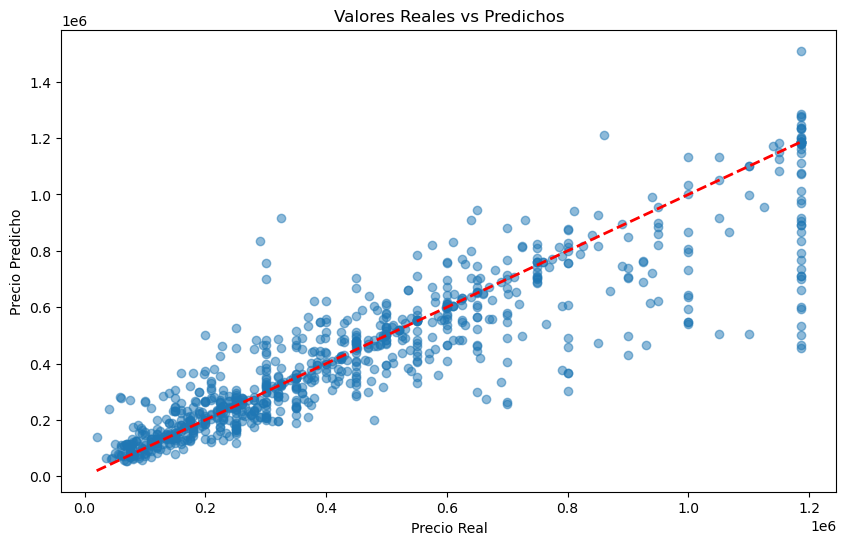

In [82]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_test_pred_original, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 
         'r--', lw=2)
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Valores Reales vs Predichos')
plt.show()

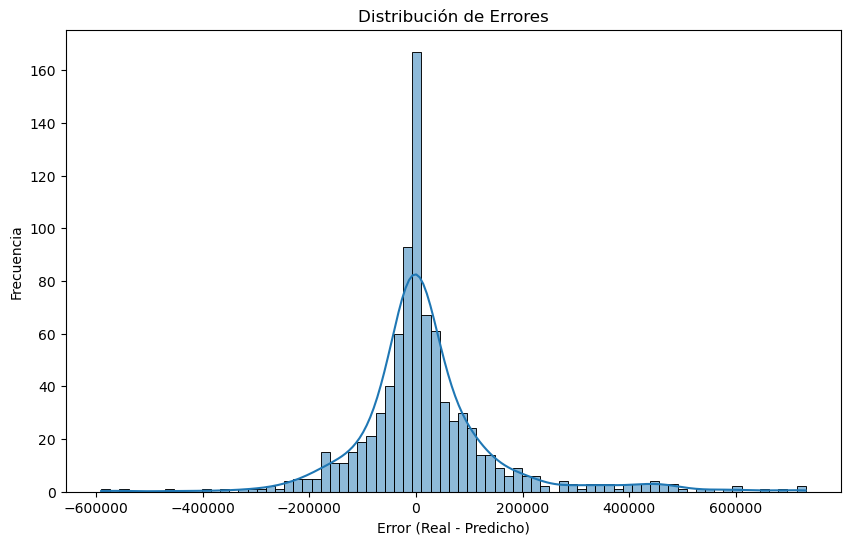

In [84]:
errors = y_test_original - y_test_pred_original
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.title('Distribución de Errores')
plt.xlabel('Error (Real - Predicho)')
plt.ylabel('Frecuencia')
plt.show()

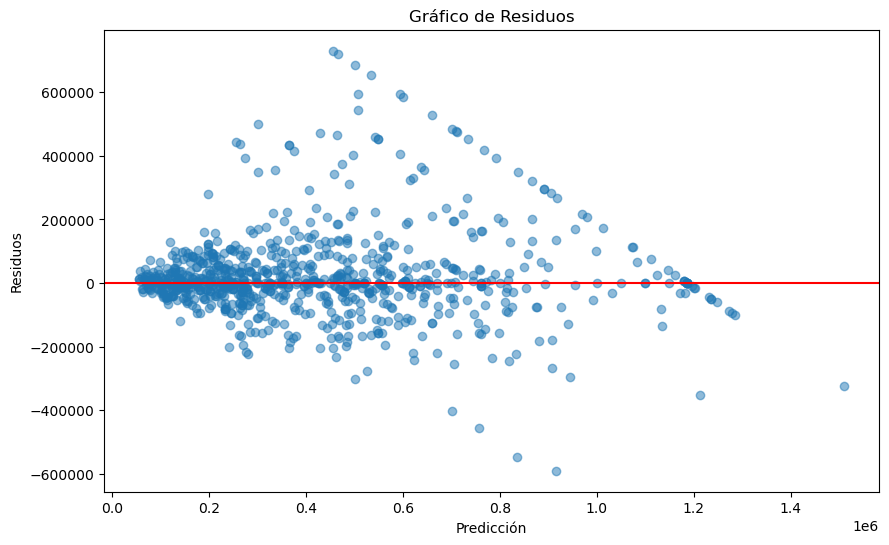

In [86]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_original, errors, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicción')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.show()

In [88]:
feature_names = []

In [90]:
num_features = model.named_steps['preprocessor'].transformers_[0][1][1].get_feature_names_out(numerical_cols)
feature_names.extend(num_features)

In [92]:
cat_features = model.named_steps['preprocessor'].transformers_[1][1][0].get_feature_names_out(categorical_cols)
feature_names.extend(cat_features)

In [94]:
coefficients = model.named_steps['regressor'].coef_

In [96]:
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

Top 10 características más importantes:
                             Feature  Coefficient  Abs_Coefficient
968   name_Mercedes-Benz E-Class 230     1.951924         1.951924
1136               name_Tata Nano CX    -1.696082         1.696082
1145         name_Tata Nano Std BSII    -1.582120         1.582120
803   name_Maruti Gypsy King HT BSIV     1.522891         1.522891
1138         name_Tata Nano Cx BSIII    -1.521730         1.521730
1144              name_Tata Nano STD    -1.485578         1.485578
1147         name_Tata Nano Twist XT    -1.476265         1.476265
219           name_Ford Ikon 1.4 ZXi    -1.417477         1.417477
1084             name_Tata Indica DL    -1.369954         1.369954
1201           name_Toyota Camry M/t     1.342881         1.342881


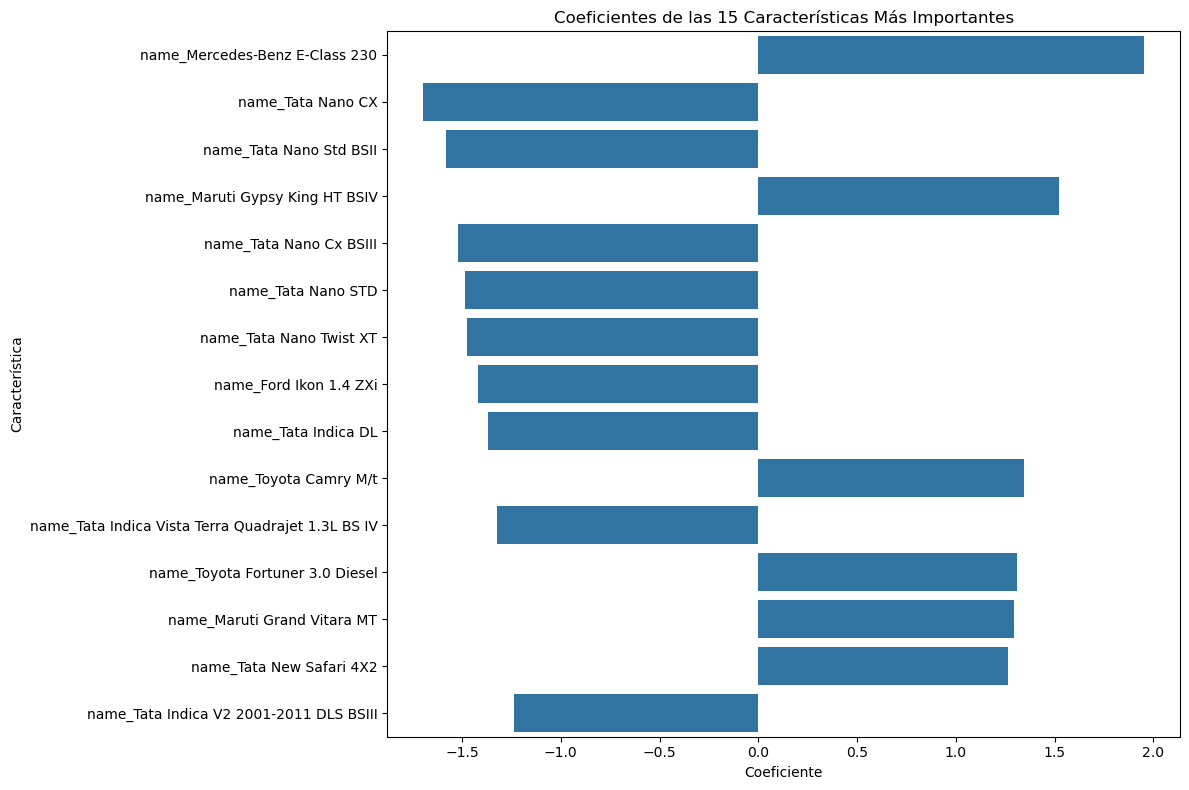

In [103]:
print("Top 10 características más importantes:")
print(feature_importance.head(10))

# Visualización de las características más importantes
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(15))
plt.title('Coeficientes de las 15 Características Más Importantes')
plt.xlabel('Coeficiente')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

Interpretar, analizar y documentar los resultados obtenidos

El modelo de regresión entrenado mostró un excelente desempeño en escala logarítmica, con un R² de 0.9564 en entrenamiento y  0.8331 en prueba, indicando que explica bien la variabilidad de los precios. En escala original, el modelo también mantuvo buenos resultados de 0.9628 y 0.8007, aunque con un error absoluto medio más elevado en prueba, como es esperado por la dispersión natural de precios.

La interpretación del modelo reveló las características más influyentes sobre el precio, destacándose modelos específicos de autos, como el Ford Ikon 1.6 ZXI NXt y el Tata Nano, como factores importantes para la predicción.